In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator

!pip install catboost
!pip install optuna
!pip install optuna_integration

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import optuna

# EDA и Feature Engineering

Рассмотрим датасет, который содержит данные о погоде в разных мест Австралии за 10 лет.

Нам интересно уметь предсказывать значение признака **RainTomorrow** -- будет ли завтра дождь, или нет. Признак, соответственно, имеет два значения -- "Yes" или "No".

In [4]:
df = pd.read_csv("weatherAUS.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Отбросим объекты, для которых неизвестно значение целевого признака

In [6]:
print(df['RainTomorrow'].isnull().sum())
df.drop(df[df['RainTomorrow'].isnull()].index, inplace=True)

3267


Поскольку датасет довольно большой, в целях экономии времени при обучении отбросим часть объектов. Поскольку объекты отсортированы по времени, а сами наблюдения производитились в течение 10 лет, на качество данных это не повляет.

In [7]:
df = df.head(50000)

Обратим внимание на баланс классов -- дождливых дней значительно меньше, что вполне ожидаемо.

<Axes: xlabel='RainTomorrow', ylabel='count'>

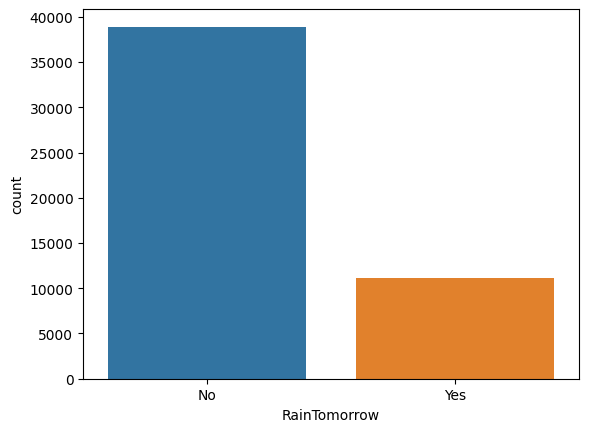

In [8]:
sns.countplot(data=df, x="RainTomorrow", hue="RainTomorrow")

Теперь посмотрим, как зависит погода завтра от того, был ли дождь сегодня.

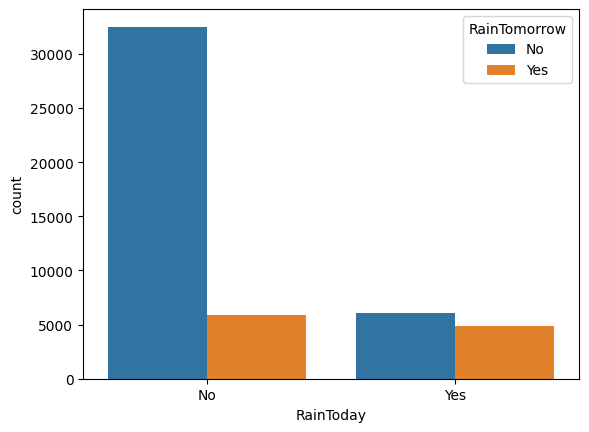

In [9]:
sns.countplot(x = 'RainToday', hue = 'RainTomorrow', data = df);

Можно заметить, что если сегодня дождя нет, то, вероятнее всего, его не будет и завтра. Но если сегодня есть дождь, то завтра он может быть или не быть с примерно одинаковой вероятностью.

Посмотрим, в каких локациях производились наблюдения. Можно отметить, что почти для всех локаций количество объектов одинаково. А вот различие между дождливым и недождлинвым прогнозами -- заметное.

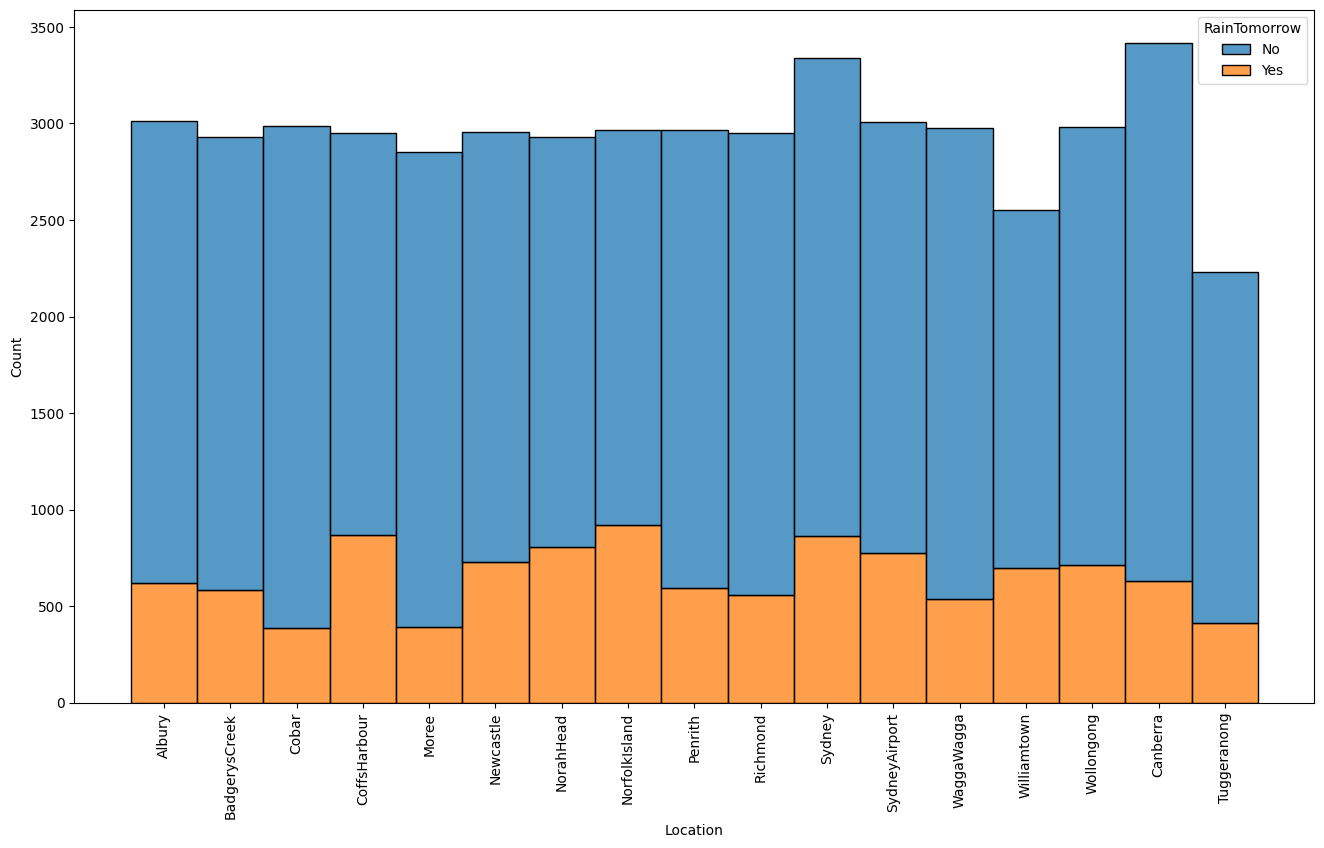

In [10]:
plt.figure(figsize=(16,9))
ax = sns.histplot(data=df, x="Location", hue="RainTomorrow", multiple="stack")
plt.xticks(rotation=90)
plt.show()

Посмотрим на связь часов, когда небо было ясным(sunshine) от количества осадков в мм (rainfaill)

<Axes: xlabel='Sunshine', ylabel='Rainfall'>

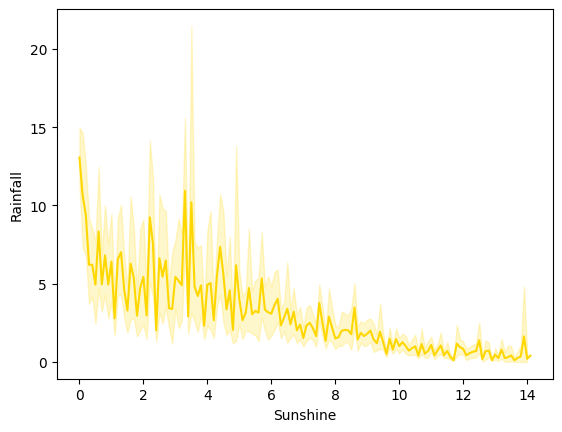

In [11]:
sns.lineplot(data=df, x='Sunshine', y='Rainfall', color='#FFD700')

Действительно в более ясные дни общее кол-во осадков меньше.

Рассмотрим категориальные признаки и количество пропущенных значений для кажддого из них.

In [12]:
s = (df.dtypes == "object")
cat_cols = list(s[s].index)
for i in cat_cols:
    print(i, df[i].isnull().sum())

Date 0
Location 0
WindGustDir 5055
WindDir9am 5532
WindDir3pm 2218
RainToday 633
RainTomorrow 0


 Заполним пропущенные значения самыми часто встречающимися.

In [13]:
for i in cat_cols:
    df[i].fillna(df[i].mode()[0], inplace=True)

Отдельно рассмотрим признак Date. Он содержит дату наблюдения (число, месяц, год). Сама по себе дата может быть не очень полезна для предсказании. Однако интерес может представлять месяц, в который было произведено наблюдение, т.к. весьма вероятно, что в какие-то месяцы осадков было больше или прогнозы удавались точнее.

In [14]:
def get_month(date):
    return int(date[5:7])

df['month'] = df['Date'].apply(get_month)
df.drop(columns=['Date'], inplace=True)
cat_cols.remove('Date')

<Axes: xlabel='month', ylabel='count'>

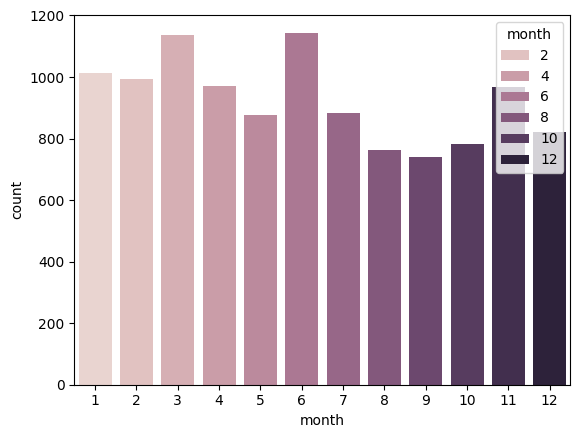

In [15]:
sns.countplot(data=df[df['RainTomorrow']=="Yes"], x="month", hue="month")

Действительно, можно увидеть, что на июнь приходится больше всего дождливых дней.

Рассмотрим количественные признаки и кол-во пропущенных значений.

In [16]:
t = (df.dtypes == "float64")
num_cols = list(t[t].index)
for i in num_cols:
    print(i, df[i].isnull().sum())

MinTemp 367
MaxTemp 193
Rainfall 633
Evaporation 26265
Sunshine 31588
WindGustSpeed 5049
WindSpeed9am 925
WindSpeed3pm 1546
Humidity9am 612
Humidity3pm 1217
Pressure9am 6721
Pressure3pm 6676
Cloud9am 20951
Cloud3pm 21402
Temp9am 342
Temp3pm 988


 Заполним пропущенные значения медианой.

In [17]:
for i in num_cols:
    df[i].fillna(df[i].median(), inplace=True)

Рассмотрим корреляционную матрицу среди количественных признаков.

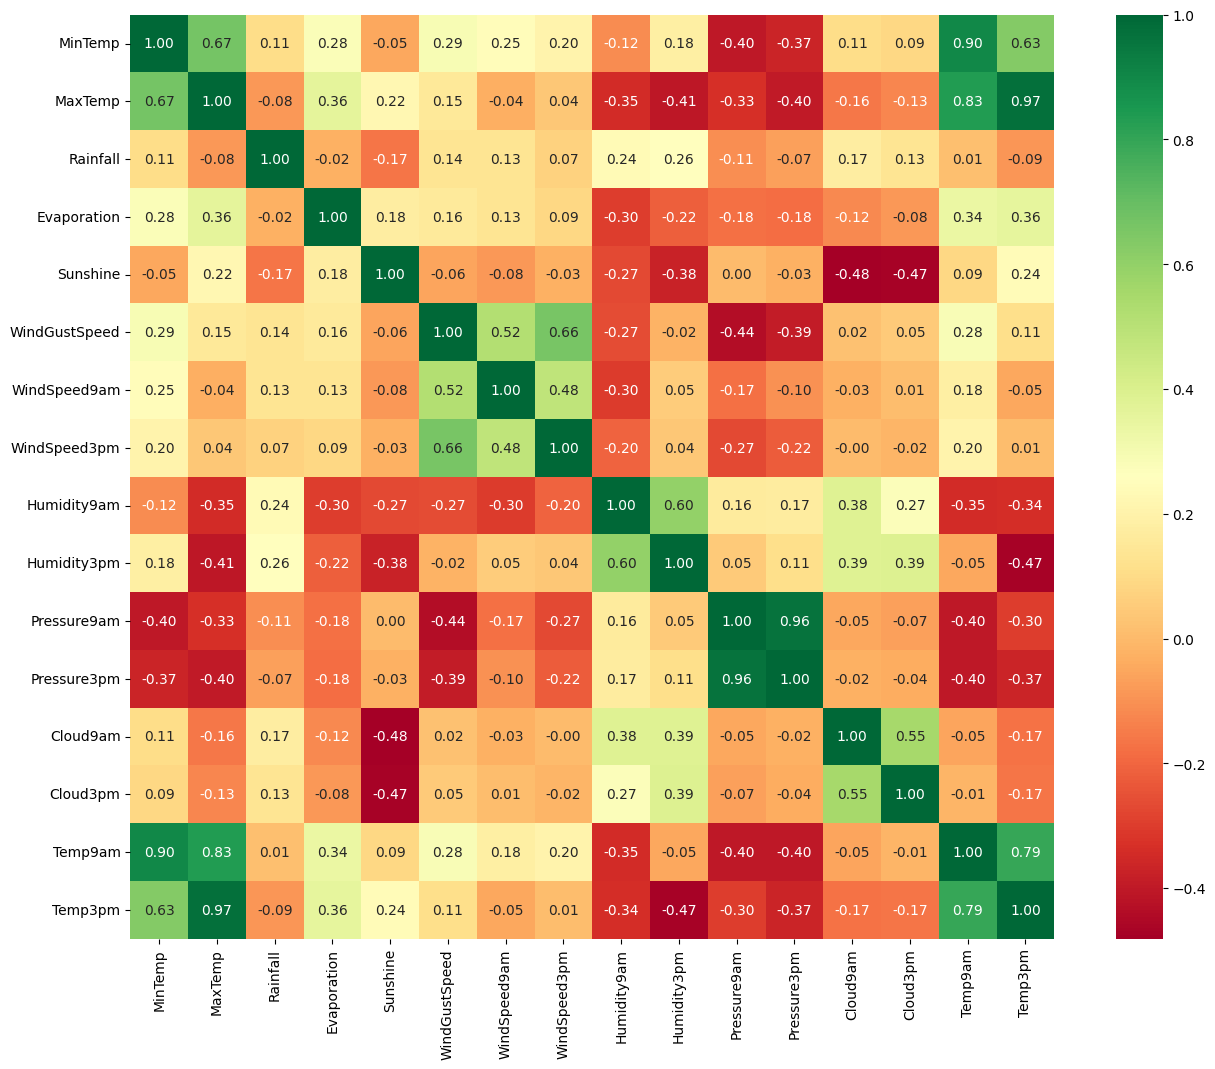

In [18]:
correlation = df[num_cols].corr()
plt.figure(figsize=(16,12))
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white', cmap='RdYlGn')
plt.show()

Можно заметить, что сильно коррелирую пара Pressure9am и Pressure3pm, а так же MinTemp, MaxTemp с разными значениями температуры. Отбросим эти признаки:

In [19]:
df = df.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am', 'Humidity9am'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 51287
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       50000 non-null  object 
 1   MinTemp        50000 non-null  float64
 2   MaxTemp        50000 non-null  float64
 3   Rainfall       50000 non-null  float64
 4   Evaporation    50000 non-null  float64
 5   Sunshine       50000 non-null  float64
 6   WindGustDir    50000 non-null  object 
 7   WindGustSpeed  50000 non-null  float64
 8   WindDir9am     50000 non-null  object 
 9   WindDir3pm     50000 non-null  object 
 10  WindSpeed9am   50000 non-null  float64
 11  WindSpeed3pm   50000 non-null  float64
 12  Humidity3pm    50000 non-null  float64
 13  Pressure3pm    50000 non-null  float64
 14  Cloud9am       50000 non-null  float64
 15  Cloud3pm       50000 non-null  float64
 16  RainToday      50000 non-null  object 
 17  RainTomorrow   50000 non-null  object 
 18  month      

Закодируем значения категориальных переменных с помощью чисел

In [20]:
enc = OrdinalEncoder()
df[cat_cols] = enc.fit_transform(df[cat_cols])

# Реализация алгоритмов

## CustomBagging

In [21]:
#from typing import Tuple
from sklearn.base import ClassifierMixin, clone
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator
from collections import Counter
def get_most_frequent(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

np.random.seed(42)

class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state


    def fit(self, X, y):
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)

        self.estimator_ = self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeClassifier()
        self.classes_ = np.unique(y)

        self.estimators_ = []
        for i in range(self.n_estimators):
            estimator = clone(self.estimator_)
            random_states = {}
            for param_name in estimator.get_params(deep=True):
                if param_name == "random_state" or param_name.endswith("__random_state"):
                    random_states[param_name] = self.random_state_
            estimator.set_params(**random_states)


            indices = self.random_state_.choice(len(y), size=len(y))
            X_mini, y_mini = X[indices], y[indices]

            estimator.fit(X_mini, y_mini)
            self.estimators_.append(estimator)

        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        predictions = [estimator.predict(X) for estimator in self.estimators_]
        return np.apply_along_axis(get_most_frequent,axis=0, arr=predictions)

## CustomAdaBoost

In [22]:
class CustomAdaBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, n_estimators=50, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y):
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)

        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeClassifier(max_depth=3)
        self.classes_ = np.unique(y)

        self.estimators_ = []
        self.estimator_weights_ = []
        sample_weight = np.ones(len(y)) / len(y)
        for i in range(self.n_estimators):
            estimator = clone(self.estimator_)
            predicted = estimator.fit(X, y, sample_weight=sample_weight).predict(X)
            errors = predicted != y
            avg_error = np.average(errors, weights=sample_weight)
            if avg_error == 0:
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                break
            if avg_error >= 0.5:
                if not self.estimators_:
                    self.estimators_.append(estimator)
                    self.estimator_weights_.append(1.0)
                break

            beta = avg_error / (1 - avg_error)
            sample_weight *=  np.exp(beta * (~errors))
            sample_weight /= np.sum(sample_weight)
            self.estimators_.append(estimator)
            self.estimator_weights_.append(np.log(1 / beta))
        self.estimator_weights_ = np.array(self.estimator_weights_)
        self.n_features_in_ = X.shape[1]
        return self


    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T
        sorted_prediction_ids = np.argsort(predictions, axis=1)
        sorted_weights_cumsum = np.cumsum(self.estimator_weights_[sorted_prediction_ids], axis=1)
        more_than_median = sorted_weights_cumsum >= (sorted_weights_cumsum[0][-1] / 2)
        median_ids = np.argmax(more_than_median, axis=1)
        median_ids = sorted_prediction_ids[np.arange(X.shape[0]), median_ids]
        return predictions[np.arange(X.shape[0]), median_ids]

# Обучение моделей

Выделим целевой признак, разобъём выборку на тестовую и обучающую

In [23]:
X = df.drop('RainTomorrow', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, df['RainTomorrow'], test_size=0.1, random_state=13)

Реализуем вспомогательную функцию для подбора гиперпараметров с помощью фреймворка Optuna

In [24]:
def param_search_helper(estimator, grid):
    study = optuna.create_study(
        sampler=optuna.samplers.BruteForceSampler(),
        direction="maximize",
    )

    # подбор гиперпараметров с кросс-валидацией
    optuna_model = optuna.integration.OptunaSearchCV(
        estimator,
        grid,
        cv=5,
        scoring="f1",
        study=study,
        n_jobs=4,
        n_trials=None,
        random_state=13,
    )

    optuna_model.fit(X_train, y_train)
    print(f"Best params: {optuna_model.best_params_} with score {optuna_model.best_score_}")

    return optuna_model.best_params_


## CustomBagging

In [25]:
best = param_search_helper(
    CustomBaggingClassifier(),
    grid={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    }
)

[I 2024-09-26 08:57:38,736] A new study created in memory with name: no-name-05356d9e-1cb6-437c-a743-3d644085f2a7
[I 2024-09-26 08:58:33,232] Trial 0 finished with value: 0.5597299039628766 and parameters: {'n_estimators': 5}. Best is trial 0 with value: 0.5597299039628766.
[I 2024-09-26 08:59:48,720] Trial 2 finished with value: 0.5735171180773786 and parameters: {'n_estimators': 20}. Best is trial 2 with value: 0.5735171180773786.
[I 2024-09-26 08:59:49,546] Trial 3 finished with value: 0.5762331050946559 and parameters: {'n_estimators': 20}. Best is trial 3 with value: 0.5762331050946559.
[I 2024-09-26 09:00:33,579] Trial 1 finished with value: 0.5854107250343017 and parameters: {'n_estimators': 40}. Best is trial 1 with value: 0.5854107250343017.


Best params: {'n_estimators': 40} with score 0.5854107250343017


In [26]:
import time
results = pd.DataFrame({"model": [], "time": [], "accuracy": [], "f1": []})

start = time.time()
model = CustomBaggingClassifier(
   **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_custom_bagging = model.predict(X_test)
row = pd.DataFrame({
    "model": "CustomBaggingClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_custom_bagging),
    "f1": f1_score(y_test, y_pred_custom_bagging)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

                     model       time  accuracy        f1
0  CustomBaggingClassifier  22.320464    0.8456  0.586724


## CustomAdaBoost

In [27]:
best = param_search_helper(
    CustomAdaBoostClassifier(),
    grid={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    }
)

[I 2024-09-26 09:01:17,655] A new study created in memory with name: no-name-35abeda5-9126-45ff-96dc-4cb3e19c6345
[I 2024-09-26 09:01:24,572] Trial 2 finished with value: 0.44712765831380397 and parameters: {'n_estimators': 5}. Best is trial 2 with value: 0.44712765831380397.
[I 2024-09-26 09:01:41,674] Trial 0 finished with value: 0.44793132490980814 and parameters: {'n_estimators': 20}. Best is trial 0 with value: 0.44793132490980814.
[I 2024-09-26 09:01:42,396] Trial 3 finished with value: 0.44793132490980814 and parameters: {'n_estimators': 20}. Best is trial 0 with value: 0.44793132490980814.
[I 2024-09-26 09:01:50,682] Trial 1 finished with value: 0.44793132490980814 and parameters: {'n_estimators': 40}. Best is trial 0 with value: 0.44793132490980814.


Best params: {'n_estimators': 20} with score 0.44793132490980814


In [28]:
start = time.time()
model = CustomAdaBoostClassifier(
   **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_custom_ada = model.predict(X_test)
row = pd.DataFrame({
    "model": "CustomAdaBoostClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_custom_ada),
    "f1": f1_score(y_test, y_pred_custom_ada)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

                      model      time  accuracy        f1
0  CustomAdaBoostClassifier  2.187218    0.8248  0.422164


## BaggingClassifier

In [29]:
best = param_search_helper(
    BaggingClassifier(random_state=13, n_jobs=4),
    grid={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    }
)

[I 2024-09-26 09:01:54,903] A new study created in memory with name: no-name-f9829cc1-5bba-4733-9c1d-2f6ca4c9ef55
[I 2024-09-26 09:03:46,940] Trial 0 finished with value: 0.5713251079464171 and parameters: {'n_estimators': 20}. Best is trial 0 with value: 0.5713251079464171.
[I 2024-09-26 09:03:58,637] Trial 3 finished with value: 0.5713251079464171 and parameters: {'n_estimators': 20}. Best is trial 0 with value: 0.5713251079464171.
[I 2024-09-26 09:03:58,668] Trial 1 finished with value: 0.5620737210841475 and parameters: {'n_estimators': 5}. Best is trial 0 with value: 0.5713251079464171.
[I 2024-09-26 09:03:59,110] Trial 2 finished with value: 0.580982835011249 and parameters: {'n_estimators': 40}. Best is trial 2 with value: 0.580982835011249.


Best params: {'n_estimators': 40} with score 0.580982835011249


In [30]:
start = time.time()
model = BaggingClassifier(
   **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_bagging = model.predict(X_test)
row = pd.DataFrame({
    "model": "BaggingClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_bagging),
    "f1": f1_score(y_test, y_pred_bagging)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

               model       time  accuracy        f1
0  BaggingClassifier  16.665947    0.8404  0.568649


## RandomForestClassifier

In [31]:
best = param_search_helper(
    RandomForestClassifier(random_state=13, n_jobs=4),
    grid={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 50]),
        "max_features": optuna.distributions.CategoricalDistribution([2, "sqrt", None]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
    }
)

[I 2024-09-26 09:04:30,325] A new study created in memory with name: no-name-af2d8250-02a1-4e7e-ac6a-030ad7b5fa35
[I 2024-09-26 09:04:43,944] Trial 3 finished with value: 0.5192697333342261 and parameters: {'n_estimators': 20, 'max_features': 2, 'max_leaf_nodes': 100}. Best is trial 3 with value: 0.5192697333342261.
[I 2024-09-26 09:04:48,417] Trial 4 finished with value: 0.5029062449035421 and parameters: {'n_estimators': 5, 'max_features': 2, 'max_leaf_nodes': 100}. Best is trial 3 with value: 0.5192697333342261.
[I 2024-09-26 09:04:50,564] Trial 1 finished with value: 0.5636280676877771 and parameters: {'n_estimators': 20, 'max_features': 2, 'max_leaf_nodes': None}. Best is trial 1 with value: 0.5636280676877771.
[I 2024-09-26 09:05:21,623] Trial 0 finished with value: 0.5600197775696382 and parameters: {'n_estimators': 20, 'max_features': None, 'max_leaf_nodes': 100}. Best is trial 1 with value: 0.5636280676877771.
[I 2024-09-26 09:05:22,802] Trial 6 finished with value: 0.50384590

Best params: {'n_estimators': 50, 'max_features': None, 'max_leaf_nodes': None} with score 0.584250375635976


In [32]:
start = time.time()
model = RandomForestClassifier(
    **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_rf = model.predict(X_test)
row = pd.DataFrame({
    "model": "RandomForestClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

                    model       time  accuracy        f1
0  RandomForestClassifier  19.821711     0.844  0.583778


## AdaBoostClassifier

In [33]:
best = param_search_helper(
    AdaBoostClassifier(random_state=13),
    grid={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 40]),
    }
)

[I 2024-09-26 09:09:52,057] A new study created in memory with name: no-name-0eee893c-f1e1-4e99-8f49-da235e159563
[I 2024-09-26 09:09:56,302] Trial 1 finished with value: 0.49585440984473567 and parameters: {'learning_rate': 0.03, 'n_estimators': 5}. Best is trial 1 with value: 0.49585440984473567.
[I 2024-09-26 09:10:04,879] Trial 2 finished with value: 0.5096918085031252 and parameters: {'learning_rate': 0.3, 'n_estimators': 20}. Best is trial 2 with value: 0.5096918085031252.
[I 2024-09-26 09:10:05,331] Trial 3 finished with value: 0.4694787828821557 and parameters: {'learning_rate': 0.03, 'n_estimators': 20}. Best is trial 2 with value: 0.5096918085031252.
[I 2024-09-26 09:10:09,558] Trial 6 finished with value: 0.5068194758312057 and parameters: {'learning_rate': 0.1, 'n_estimators': 5}. Best is trial 2 with value: 0.5096918085031252.
[I 2024-09-26 09:10:17,905] Trial 0 finished with value: 0.45373548172026473 and parameters: {'learning_rate': 0.03, 'n_estimators': 40}. Best is tr

Best params: {'learning_rate': 0.3, 'n_estimators': 40} with score 0.5340429817247538


In [34]:
start = time.time()
model = AdaBoostClassifier(
   **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_adaboost = model.predict(X_test)
row = pd.DataFrame({
    "model": "AdaBoostClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_adaboost),
    "f1": f1_score(y_test, y_pred_adaboost)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

                model      time  accuracy        f1
0  AdaBoostClassifier  1.781394    0.8324  0.526554


## GradientBoostingClassifier

In [35]:
best = param_search_helper(
    GradientBoostingClassifier(random_state=13),
    grid={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
    }
)

[I 2024-09-26 09:10:28,302] A new study created in memory with name: no-name-b8780467-dd74-483e-b0bf-aa791900d20c
[I 2024-09-26 09:10:34,490] Trial 2 finished with value: 0.2567850585903909 and parameters: {'learning_rate': 0.1, 'n_estimators': 5, 'max_leaf_nodes': 100}. Best is trial 2 with value: 0.2567850585903909.
[I 2024-09-26 09:10:55,417] Trial 1 finished with value: 0.5053855488947653 and parameters: {'learning_rate': 0.1, 'n_estimators': 20, 'max_leaf_nodes': 10}. Best is trial 1 with value: 0.5053855488947653.
[I 2024-09-26 09:10:55,586] Trial 3 finished with value: 0.5653604136123066 and parameters: {'learning_rate': 0.3, 'n_estimators': 20, 'max_leaf_nodes': 100}. Best is trial 3 with value: 0.5653604136123066.
[I 2024-09-26 09:10:56,128] Trial 0 finished with value: 0.2928968693288447 and parameters: {'learning_rate': 0.03, 'n_estimators': 20, 'max_leaf_nodes': 100}. Best is trial 3 with value: 0.5653604136123066.
[I 2024-09-26 09:11:01,826] Trial 7 finished with value: 0.

Best params: {'learning_rate': 0.3, 'n_estimators': 100, 'max_leaf_nodes': None} with score 0.5992203997010531


In [36]:
start = time.time()
model = GradientBoostingClassifier(
    **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_gb = model.predict(X_test)
row = pd.DataFrame({
    "model": "GradientBoostingClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_gb),
    "f1": f1_score(y_test, y_pred_gb)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

                        model       time  accuracy        f1
0  GradientBoostingClassifier  10.464925     0.851  0.602667


## HistGradientBoostingClassifier

In [37]:
best = param_search_helper(
    HistGradientBoostingClassifier(random_state=13),
    grid={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.1, 0.2, 0.3]),
        "max_iter": optuna.distributions.CategoricalDistribution([100, 300, 500]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([3, 15, 40]),
        "early_stopping": optuna.distributions.CategoricalDistribution([False, True]),
    }
)

[I 2024-09-26 09:17:06,204] A new study created in memory with name: no-name-9e41b03a-08dc-4a50-9bcd-7c819106cce8
[I 2024-09-26 09:17:17,529] Trial 3 finished with value: 0.6012269187915033 and parameters: {'learning_rate': 0.3, 'max_iter': 100, 'max_leaf_nodes': 40, 'early_stopping': True}. Best is trial 3 with value: 0.6012269187915033.
[I 2024-09-26 09:17:19,716] Trial 2 finished with value: 0.5980180307514051 and parameters: {'learning_rate': 0.3, 'max_iter': 500, 'max_leaf_nodes': 15, 'early_stopping': True}. Best is trial 3 with value: 0.6012269187915033.
[I 2024-09-26 09:17:20,677] Trial 1 finished with value: 0.5979972305122868 and parameters: {'learning_rate': 0.2, 'max_iter': 100, 'max_leaf_nodes': 15, 'early_stopping': False}. Best is trial 3 with value: 0.6012269187915033.
[I 2024-09-26 09:17:30,643] Trial 4 finished with value: 0.5980180307514051 and parameters: {'learning_rate': 0.3, 'max_iter': 300, 'max_leaf_nodes': 15, 'early_stopping': True}. Best is trial 3 with valu

Best params: {'learning_rate': 0.1, 'max_iter': 500, 'max_leaf_nodes': 40, 'early_stopping': False} with score 0.6218940210146388


In [38]:
start = time.time()
model = HistGradientBoostingClassifier(
    **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_hgb = model.predict(X_test)
row = pd.DataFrame({
    "model": "HistGradientBoostingClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_hgb),
    "f1": f1_score(y_test, y_pred_hgb)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

                            model      time  accuracy        f1
0  HistGradientBoostingClassifier  5.401372     0.854  0.621762


## XGBClassifier from XGBoost

In [39]:
best = param_search_helper(
    XGBClassifier(random_state=13, nthread=4),
    grid={
        "tree_method": optuna.distributions.CategoricalDistribution(["exact", "approx", "hist"]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "max_leaves": optuna.distributions.CategoricalDistribution([3, 15, 40]),
    }
)

[I 2024-09-26 09:23:51,974] A new study created in memory with name: no-name-5074d1d8-a7d2-4fb3-94d8-21be72b1d1bf
[I 2024-09-26 09:23:56,564] Trial 0 finished with value: 0.0 and parameters: {'tree_method': 'approx', 'learning_rate': 0.1, 'n_estimators': 5, 'max_leaves': 3}. Best is trial 0 with value: 0.0.
[I 2024-09-26 09:23:57,675] Trial 1 finished with value: 0.0 and parameters: {'tree_method': 'exact', 'learning_rate': 0.03, 'n_estimators': 5, 'max_leaves': 40}. Best is trial 0 with value: 0.0.
[I 2024-09-26 09:24:02,562] Trial 5 finished with value: 0.0 and parameters: {'tree_method': 'approx', 'learning_rate': 0.03, 'n_estimators': 5, 'max_leaves': 15}. Best is trial 0 with value: 0.0.
[I 2024-09-26 09:25:01,961] Trial 3 finished with value: 0.5829072719411469 and parameters: {'tree_method': 'approx', 'learning_rate': 0.1, 'n_estimators': 100, 'max_leaves': 15}. Best is trial 3 with value: 0.5829072719411469.
[I 2024-09-26 09:25:17,364] Trial 2 finished with value: 0.56189096491

Best params: {'tree_method': 'hist', 'learning_rate': 0.3, 'n_estimators': 100, 'max_leaves': 40} with score 0.6119279081110764


In [40]:
start = time.time()
model = XGBClassifier(
    **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_xgb = model.predict(X_test)
row = pd.DataFrame({
    "model": "XGBClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_xgb),
    "f1": f1_score(y_test, y_pred_xgb)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

           model      time  accuracy        f1
0  XGBClassifier  1.898919    0.8532  0.617708


## LGBMClassifier from lightgbm

In [41]:
best = param_search_helper(
    LGBMClassifier(random_state=13, n_jobs=4),
    grid={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
        "num_leaves": optuna.distributions.CategoricalDistribution([3, 15, 40]),
    }
)

[I 2024-09-26 09:32:33,640] A new study created in memory with name: no-name-2ccbea80-9a3a-44d6-9082-f542d3d863f8
[I 2024-09-26 09:32:36,550] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.1, 'n_estimators': 5, 'num_leaves': 3}. Best is trial 2 with value: 0.0.
[I 2024-09-26 09:32:37,734] Trial 3 finished with value: 0.26779496586635704 and parameters: {'learning_rate': 0.1, 'n_estimators': 5, 'num_leaves': 40}. Best is trial 3 with value: 0.26779496586635704.
[I 2024-09-26 09:32:39,078] Trial 1 finished with value: 0.5218708646963351 and parameters: {'learning_rate': 0.1, 'n_estimators': 20, 'num_leaves': 15}. Best is trial 1 with value: 0.5218708646963351.
[I 2024-09-26 09:32:42,043] Trial 0 finished with value: 0.4891328353357102 and parameters: {'learning_rate': 0.03, 'n_estimators': 100, 'num_leaves': 3}. Best is trial 1 with value: 0.5218708646963351.
[I 2024-09-26 09:32:42,539] Trial 6 finished with value: 0.25894118450995296 and parameters: {'learning_rate

[LightGBM] [Info] Number of positive: 9948, number of negative: 35052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 45000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221067 -> initscore=-1.259461
[LightGBM] [Info] Start training from score -1.259461
Best params: {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 40} with score 0.6075435210343716


In [42]:
start = time.time()
model = LGBMClassifier(
    **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_lgbm = model.predict(X_test)
row = pd.DataFrame({
    "model": "LGBMClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_lgbm),
    "f1": f1_score(y_test, y_pred_lgbm)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

[LightGBM] [Info] Number of positive: 9948, number of negative: 35052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 45000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221067 -> initscore=-1.259461
[LightGBM] [Info] Start training from score -1.259461
            model      time  accuracy        f1
0  LGBMClassifier  0.692137    0.8484  0.611282


## CatBoostClassifier from catboost

In [43]:
best = param_search_helper(
    CatBoostClassifier(random_state=13, thread_count=4),
    grid={
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 300, 500]),
    }
)

[I 2024-09-26 09:33:37,224] A new study created in memory with name: no-name-f93290bd-5dae-42c5-9769-d32cd7899135


Learning rate set to 0.143534
Learning rate set to 0.393075
0:	learn: 0.6007771	total: 82ms	remaining: 24.5s
Learning rate set to 0.08985
Learning rate set to 0.08985
0:	learn: 0.5337377	total: 46.8ms	remaining: 4.63s
1:	learn: 0.5402872	total: 121ms	remaining: 18s
1:	learn: 0.4608654	total: 76.1ms	remaining: 3.73s
0:	learn: 0.6328354	total: 70.9ms	remaining: 35.4s
2:	learn: 0.4940362	total: 168ms	remaining: 16.7s
2:	learn: 0.4242847	total: 106ms	remaining: 3.43s
0:	learn: 0.6328354	total: 62.9ms	remaining: 31.4s
3:	learn: 0.4011807	total: 139ms	remaining: 3.32s
1:	learn: 0.5870756	total: 127ms	remaining: 31.6s
1:	learn: 0.5870756	total: 115ms	remaining: 28.5s
3:	learn: 0.4626388	total: 242ms	remaining: 17.9s
4:	learn: 0.3871286	total: 179ms	remaining: 3.39s
2:	learn: 0.5474693	total: 171ms	remaining: 28.3s
2:	learn: 0.5474693	total: 163ms	remaining: 26.9s
5:	learn: 0.3783365	total: 220ms	remaining: 3.44s
4:	learn: 0.4404955	total: 290ms	remaining: 17.1s
3:	learn: 0.5165353	total: 216m

[I 2024-09-26 09:33:58,388] Trial 3 finished with value: 0.6070349662704647 and parameters: {'n_estimators': 100}. Best is trial 3 with value: 0.6070349662704647.


41:	learn: 0.3452839	total: 3.06s	remaining: 18.8s
323:	learn: 0.2909139	total: 19.9s	remaining: 10.8s
337:	learn: 0.2888827	total: 19.9s	remaining: 9.54s
42:	learn: 0.3449426	total: 3.13s	remaining: 18.7s
324:	learn: 0.2907805	total: 20s	remaining: 10.8s
338:	learn: 0.2887207	total: 20s	remaining: 9.48s
43:	learn: 0.3444618	total: 3.19s	remaining: 18.6s
339:	learn: 0.2886268	total: 20s	remaining: 9.42s
325:	learn: 0.2906006	total: 20.1s	remaining: 10.7s
44:	learn: 0.3438232	total: 3.25s	remaining: 18.4s
340:	learn: 0.2884888	total: 20.1s	remaining: 9.36s
326:	learn: 0.2903800	total: 20.1s	remaining: 10.7s
45:	learn: 0.3433333	total: 3.29s	remaining: 18.2s
341:	learn: 0.2884855	total: 20.1s	remaining: 9.29s
342:	learn: 0.2883670	total: 20.2s	remaining: 9.23s
46:	learn: 0.3428209	total: 3.36s	remaining: 18.1s
327:	learn: 0.2903050	total: 20.2s	remaining: 10.6s
343:	learn: 0.2882164	total: 20.2s	remaining: 9.17s
47:	learn: 0.3423126	total: 3.41s	remaining: 17.9s
328:	learn: 0.2902040	tot

[I 2024-09-26 09:34:54,044] Trial 0 finished with value: 0.6098264941876751 and parameters: {'n_estimators': 300}. Best is trial 0 with value: 0.6098264941876751.


486:	learn: 0.2635471	total: 14.3s	remaining: 381ms
487:	learn: 0.2634731	total: 14.3s	remaining: 351ms
488:	learn: 0.2633938	total: 14.3s	remaining: 321ms
Learning rate set to 0.08985
489:	learn: 0.2632867	total: 14.3s	remaining: 292ms
0:	learn: 0.6330566	total: 15.9ms	remaining: 7.94s
1:	learn: 0.5846440	total: 29.6ms	remaining: 7.38s
490:	learn: 0.2631783	total: 14.3s	remaining: 263ms
2:	learn: 0.5491595	total: 49ms	remaining: 8.12s
3:	learn: 0.5170911	total: 66.9ms	remaining: 8.29s
491:	learn: 0.2630739	total: 14.4s	remaining: 234ms
4:	learn: 0.4914496	total: 83.1ms	remaining: 8.22s
5:	learn: 0.4696454	total: 100ms	remaining: 8.25s
6:	learn: 0.4523749	total: 116ms	remaining: 8.18s
492:	learn: 0.2629334	total: 14.4s	remaining: 205ms
7:	learn: 0.4397320	total: 131ms	remaining: 8.06s
8:	learn: 0.4303030	total: 161ms	remaining: 8.77s
493:	learn: 0.2628062	total: 14.5s	remaining: 176ms
9:	learn: 0.4211525	total: 178ms	remaining: 8.71s
10:	learn: 0.4128478	total: 194ms	remaining: 8.61s
4

[I 2024-09-26 09:35:26,166] Trial 1 finished with value: 0.6157778000888999 and parameters: {'n_estimators': 500}. Best is trial 1 with value: 0.6157778000888999.


468:	learn: 0.2676567	total: 17.3s	remaining: 1.14s
499:	learn: 0.2641290	total: 17.7s	remaining: 0us
469:	learn: 0.2675682	total: 17.3s	remaining: 1.1s


[I 2024-09-26 09:35:27,009] Trial 2 finished with value: 0.6157778000888999 and parameters: {'n_estimators': 500}. Best is trial 1 with value: 0.6157778000888999.


Learning rate set to 0.098833
0:	learn: 0.6276124	total: 20.6ms	remaining: 10.3s
1:	learn: 0.5790127	total: 69.2ms	remaining: 17.2s
2:	learn: 0.5377336	total: 112ms	remaining: 18.5s
3:	learn: 0.5059516	total: 151ms	remaining: 18.7s
4:	learn: 0.4802200	total: 183ms	remaining: 18.1s
5:	learn: 0.4600513	total: 218ms	remaining: 18s
6:	learn: 0.4449833	total: 244ms	remaining: 17.2s
7:	learn: 0.4309609	total: 273ms	remaining: 16.8s
8:	learn: 0.4199656	total: 296ms	remaining: 16.2s
9:	learn: 0.4114624	total: 327ms	remaining: 16s
10:	learn: 0.4041978	total: 348ms	remaining: 15.5s
11:	learn: 0.3976274	total: 381ms	remaining: 15.5s
12:	learn: 0.3918054	total: 423ms	remaining: 15.8s
13:	learn: 0.3881828	total: 463ms	remaining: 16.1s
14:	learn: 0.3843759	total: 506ms	remaining: 16.3s
15:	learn: 0.3818729	total: 542ms	remaining: 16.4s
16:	learn: 0.3796245	total: 581ms	remaining: 16.5s
17:	learn: 0.3770525	total: 620ms	remaining: 16.6s
18:	learn: 0.3750346	total: 667ms	remaining: 16.9s
19:	learn: 0.

In [44]:
start = time.time()
model = CatBoostClassifier(
    **best
)
model.fit(X_train, y_train)
training_time = time.time() - start

y_pred_cb = model.predict(X_test)
row = pd.DataFrame({
    "model": "CatBoostClassifier",
    "time": training_time,
    "accuracy": accuracy_score(y_test, y_pred_cb),
    "f1": f1_score(y_test, y_pred_cb)
}, index=[0])
print(row)
results = pd.concat([results, row], ignore_index=True)

Learning rate set to 0.098833
0:	learn: 0.6274690	total: 12.9ms	remaining: 6.46s
1:	learn: 0.5783459	total: 26.7ms	remaining: 6.65s
2:	learn: 0.5375624	total: 41.3ms	remaining: 6.84s
3:	learn: 0.5060597	total: 56.4ms	remaining: 7s
4:	learn: 0.4800798	total: 70ms	remaining: 6.93s
5:	learn: 0.4604816	total: 84.2ms	remaining: 6.93s
6:	learn: 0.4447819	total: 97.6ms	remaining: 6.87s
7:	learn: 0.4295169	total: 119ms	remaining: 7.32s
8:	learn: 0.4190676	total: 136ms	remaining: 7.43s
9:	learn: 0.4107516	total: 150ms	remaining: 7.35s
10:	learn: 0.4030156	total: 164ms	remaining: 7.27s
11:	learn: 0.3966271	total: 178ms	remaining: 7.24s
12:	learn: 0.3921904	total: 191ms	remaining: 7.17s
13:	learn: 0.3888701	total: 209ms	remaining: 7.26s
14:	learn: 0.3857480	total: 223ms	remaining: 7.22s
15:	learn: 0.3826839	total: 237ms	remaining: 7.18s
16:	learn: 0.3800423	total: 251ms	remaining: 7.14s
17:	learn: 0.3772915	total: 267ms	remaining: 7.14s
18:	learn: 0.3757595	total: 280ms	remaining: 7.1s
19:	learn:

# Анализ результатов

<Axes: title={'center': 'CustomAdaBoost Confusion Matrix'}>

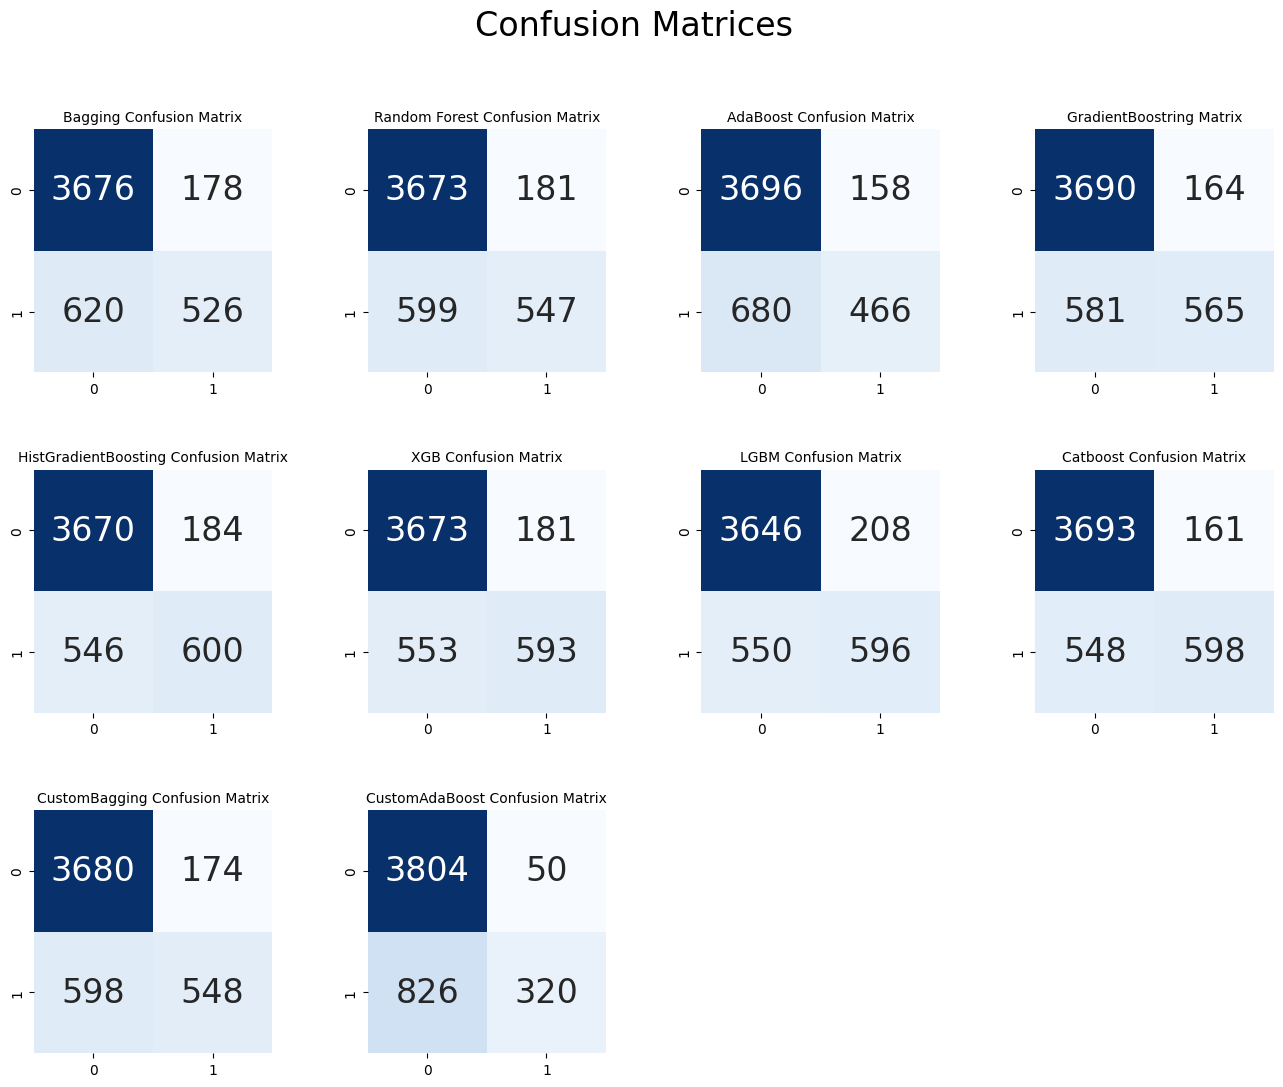

In [45]:
from sklearn.metrics import confusion_matrix

cm_custom_bagging = confusion_matrix(y_test, y_pred_custom_bagging)
cm_custom_ada = confusion_matrix(y_test, y_pred_custom_ada)
cm_bagging = confusion_matrix(y_test, y_pred_bagging)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_hgb = confusion_matrix(y_test, y_pred_hgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_cb = confusion_matrix(y_test, y_pred_cb)

plt.figure(figsize=(16, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(3,4,1)
plt.title("Bagging Confusion Matrix", fontsize=10)
sns.heatmap(cm_bagging,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,2)
plt.title("Random Forest Confusion Matrix", fontsize=10)
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,3)
plt.title("AdaBoost Confusion Matrix", fontsize=10)
sns.heatmap(cm_adaboost,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,4)
plt.title("GradientBoostring Matrix", fontsize=10)
sns.heatmap(cm_gb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,5)
plt.title("HistGradientBoosting Confusion Matrix", fontsize=10)
sns.heatmap(cm_hgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,6)
plt.title("XGB Confusion Matrix", fontsize=10)
sns.heatmap(cm_xgb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,7)
plt.title("LGBM Confusion Matrix", fontsize=10)
sns.heatmap(cm_lgbm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,8)
plt.title("Catboost Confusion Matrix", fontsize=10)
sns.heatmap(cm_cb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,9)
plt.title("CustomBagging Confusion Matrix", fontsize=10)
sns.heatmap(cm_custom_bagging,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(3,4,10)
plt.title("CustomAdaBoost Confusion Matrix", fontsize=10)
sns.heatmap(cm_custom_ada,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CustomBaggingClassifier'),
  Text(1, 0, 'CustomAdaBoostClassifier'),
  Text(2, 0, 'BaggingClassifier'),
  Text(3, 0, 'RandomForestClassifier'),
  Text(4, 0, 'AdaBoostClassifier'),
  Text(5, 0, 'GradientBoostingClassifier'),
  Text(6, 0, 'HistGradientBoostingClassifier'),
  Text(7, 0, 'XGBClassifier'),
  Text(8, 0, 'LGBMClassifier'),
  Text(9, 0, 'CatBoostClassifier')])

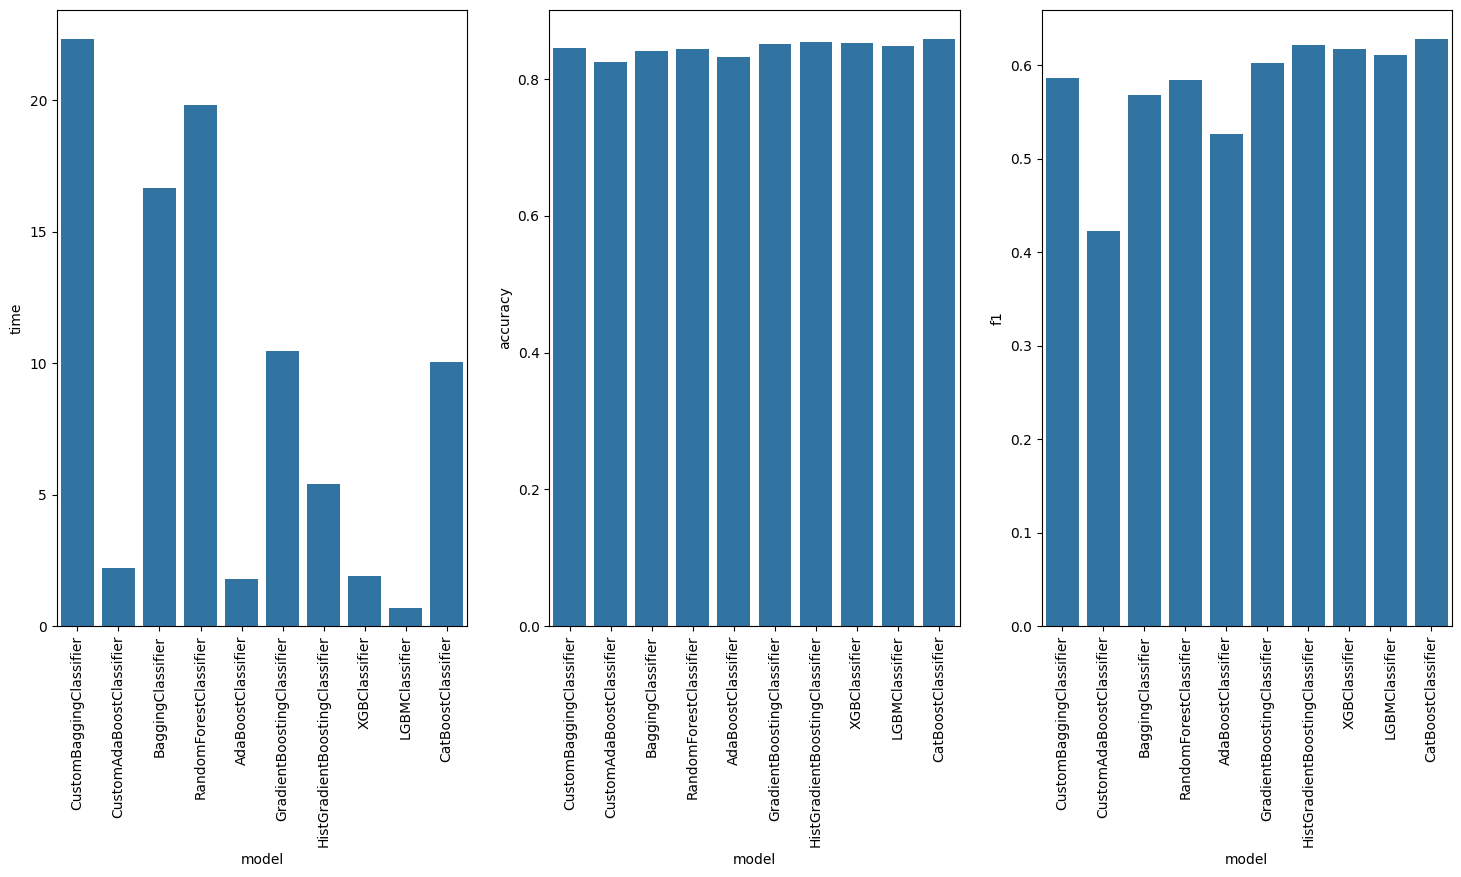

In [46]:
plt.figure(figsize=(18, 8))
plt.subplot(1,3,1)
sns.barplot(data=results, x="model", y="time")
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.barplot(data=results, x="model", y="accuracy")
plt.xticks(rotation=90)
plt.subplot(1,3,3)
sns.barplot(data=results, x="model", y="f1")
plt.xticks(rotation=90)

**Вывод**

Почти все классификаторы показали одинаковый результат по метрике accuracy.
Однако, из-за того что классы несбалансированы, более интересен оказался результат по метрике f1. Наменьшее значение из библиотечных моделей показал классификатор AdaBoost, а наибольшее -- HistGradientBoosting. Самый низкий результат показал CustomAdaBoosting. При этом интересно, что CustomBagging дал результат не хуже других моделей.

Быстрее всех обучались HistGradientBoosting и LGBMClassifier, а медленнее всех - CatBoostClassifier. При этом интересно отметить, что HistGradientBoosting показал хороший результат.

Из анализа матриц ошибок можно заметить, что все модели неплохо определяют объекты класса 0 (дождя завтра не будет), при этом достаточно плохо справляются с определением объектов класса 1 (дождь завтра будет). Лучше всего с этим справилась опять же модель HistGradientBoostingClassifier.